# maysics.algorithm模块使用说明

algorithm模块包含五个类：

|名称|作用|
|---|---|
|MC|蒙特卡洛模拟|
|GA|遗传算法|
|SA|模拟退火算法|
|GD|梯度下降算法|
|GM|灰色系统GM(1,1)|

<br></br>
## MC：蒙特卡洛模拟

### MC下设四个可调用函数
```sel_ind```、```sel_any```、```sel_con```、```fit```
<br>其中，```fit```函数是核心函数，用于启动模拟

### 读取模拟结果
MC类有三个用于读取模拟结果的属性：```EX```、```DX```和```history```
<br>要在使用```fit```方法后，这三个属性才能调用
<br>```EX```表示最后一次使用```fit```方法的期望
<br>```DX```表示最后一次使用```fit```方法的方差
<br>```history```表示```EX```和```DX```的所有历史值
<br>```history```数据类型为字典，具体形式：```{'EX':[...], 'DX':[...]}```

### fit函数模拟原理
```fit```函数有三个参数：```length```、```dim```、```select```
<br>产生loop个length * dim的二维数组
<br>每一行称为一个状态，所以一个二维数组有length个状态
<br>一个length * dim的二维数组称为一个实验
<br>综上所述，MC的模拟结构是进行loop次模拟，每次模拟包括length个具有dim个元素的随机状态

```select```参数影响着模拟结果的生成，该参数可以是函数，也可以是函数列表
<br>无论是函数还是函数列表，都是由使用者自定义的
<br>```select```函数针对的对象一次模拟中的二维数组，即判断某一次模拟的结果如何
<br>对于输入函数的情况，```select```函数的返回值可以是任意值
<br>但是对于输入函数列表的情况，列表中各个函数的返回值只能是1或0

在每一次模拟后，由```select```函数返回的值会被计算机储存
<br>在```fit```方法进行loop次模拟后，会自动计算这些返回值的数学期望和方差
<br>数学期望和方差分别被储存在```EX```属性和```DX```属性中

### DEMO 1-1：select为函数

In [1]:
# 模拟抛硬币的过程，求硬币面的期望（正面表示1，反面表示0）
from maysics.algorithm import MC

# 返回硬币面代表的值
def select(x):
    return x[0][0]

# 产生随机数的方式是在[0, 1]内随机生成整数
mc = MC(random_type='randint', begin=0, end=1, random_state=100)

# 一次模拟就是抛一次硬币，只有一个状态和一个维度
# 所以length=1，dim=1
mc.fit(1, 1, select)

# 输出期望和方差
print('期望：', mc.EX)
print('方差：', mc.DX)

期望： 0.504
方差： 0.24998400000000004


### DEMO 1-2：select为函数列表

In [2]:
# 用1/4圆和外接正方形面积比的方法逼近pi
# 产生二维随机数(x, y)，在圆内的点数目/全部点数目 ≈ pi/4
from maysics.algorithm import MC

# 在半径为1的1/4圆内的点输出1，否则输出0
def select(x):
    if x[0][0]**2 + x[0][1]**2 < 1:
        return 1
    else:
        return 0

# 默认loop=1000，产生[0, 1)之间的随机数
mc = MC(random_state=100)

# 一次模拟为一个状态，两个维度
# 所以length=1，dim=2
mc.fit(1, 2, select)

print('pi/4：', mc.EX)
print('方差：', mc.DX)

pi/4： 0.814
方差： 0.15140400000000004


### sel_ind、sel_any和sel_con
这三个函数用于辅助编写```select```函数
<br>三个函数都有```condition```参数，该参数要求输入一个由使用者编写的函数
<br>```condition```函数类似只针对一个状态来编写的```select```函数
<br>但是```condition```函数并不如自定义的```select```函数一样可以返回各种值
<br>而是只能返回True或False，来判断某个函数是否“适格”

若某个```condtion```函数表示一个状态的所有维度之和大于10为True，否则为False
<br>则```sel_ind```函数可以编写一个```select```函数：一次模拟只有每个状态的维度之和大于0才会返回1，否则返回0
<br>```sel_any```函数可以编写一个```select```函数：一次模拟只要任意n个状态的维度之和大于0就会返回1，否则返回0
<br>```sel_con```函数可以编写一个```select```函数：一次模拟要有n个连续的状态维度之和大于0才会返回1，否则返回0
<br>具体例子如下：
### DEMO 1-3：求一个月内连续两周下雨大于等于3天的概率

In [3]:
# 已知下个月降雨率为40%
# 求一个月内连续两周下雨大于等于3天的概率
# 一次模拟是一个月的天气情况，一个月设有四周
# 则一次模拟应为4个状态，7个维度
# 即length=4，dim=7
from maysics.algorithm import MC

# 针对一个状态编写condition函数
# 根据降雨概率
# 随机数大于0.4表示晴天，小于等于0.4表示雨天
def condition(x):
    num = len(x[x <= 0.4])
    if num >= 3:
        return True
    else:
        return False

mc = MC(random_state=100)

# 通过sel_con函数生成select函数
select = mc.sel_con(3, condition)
mc.fit(4, 7, select)

print('概率：', mc.EX)
print('方差：', mc.DX)

概率： 0.268
方差： 0.196176


### 使用自定义随机数产生方法
可以在类的实例化时，修改```random_type```参数，输入自定义的随机数产生方式
### DEMO 1-4：求自由度为2的卡方分布均值和方差

In [4]:
from maysics.algorithm import MC
import numpy as np

def select(x):
    return x[0][0]


def random_f():
    return np.array([[np.random.chisquare(2)]])

# 将模拟次数调整到10000次
mc = MC(loop=10000, random_type=random_f, random_state=100)
mc.fit(length=None, dim=None, select=select)

print('均值：', mc.EX)
print('方差：', mc.DX)

均值： 1.99383007531525
方差： 4.050676069065209


### 多核计算
在类的实例化时，可以修改```n_jobs```参数，表示调用的cpu数，默认为1
<br>当设定```n_jobs=-1```时，则会调用所有的cpu进行计算
#### 注意
在设定```n_jobs```不为1时，要加上```if __name__ == "__main__":```才会起效果
<br>多核运行时需要在.py文件中运行才会起效果

<br></br>
## GA：遗传算法
GA类下仅设一个可调用函数```fit```

### 名词解释
个体：由一段长为length的染色体组成
<br>种群：population个个体组成
<br>交叉互换：两个个体之间部分染色体进行交换
<br>变异：染色体部分随机变化
<br>选择：通过一定的机制淘汰一部分个体，使得另一部分个体得以保留

### 模拟原理
随机生成种群 → 选择 → 交叉互换 → 变异 → 选择
<br>经过多次选择后得到优势个体则为问题最优解
<br>选择的标准是由使用者自定义的```fitness```函数
<br>```fitness```函数针对的对象是一个个体，返回值是个体的适应性的量化值
<br>对于有着更高“适应值”的个体，更有可能在环境中存活，即更有可能“被选择”
<br>相应地，对于“适应值”较低的个体，也有一定概率可以在“选择”中存活下来

#### 选择
选择有两种可选择方式：轮盘赌选择和随机竞争选择（默认为轮盘赌选择）
<br>轮盘赌选择：
<br>随机竞争选择：
<br>在种群中随机选择两个不同个体，比较他们的“适应值”，高的一方可以存活

#### 交叉互换
交叉互换有两种可选择方式：均匀交叉和多点交叉（默认为均匀交叉）
<br>均匀交叉：
<br>在种群中随机选择两个不同的个体，染色体的每个基因都有固定的概率会发生交换
<br>多点交叉：
<br>在种群中随机选择两个不同的个体，染色体随机的n歌基因会发生交换

#### 变异
种群中的每个个体在交叉互换后
<br>染色体的每个基因都有固定的概率（默认为0.05）发生变化（变成一个随机生成的基因）

### 适应度函数
fitness函数的输入是一个一维ndarray

### 查看模拟结果
GA类有两个可以读取模拟结果的属性：```dom```和```dom_fitness```
<br>分别可以读取最后选择的优势种和优势种中各个个体的“适应值”

### DEMO 2-1：求$f(x, y) = (x - 0.5)^{2} + (y - 0.5)^{2}$在$x\in[0, 1)，y\in[0, 1)$的最小值

In [5]:
from maysics.algorithm import GA
import numpy as np

# 将函数值+1的倒数作为“适应值”
def fitness(x):
    y = (x[0] - 0.5)**2 + (x[1] - 0.5)**2
    return 1 / (y + 1)

# 将存活率调整至3%
ga = GA(select_rate=0.03, random_state=100)

# 设定染色体长度为2（只有两个基因：x和y）
ga.fit(2, fitness)
y = 1 / ga.dom_fitness - 1

print('优势种：', ga.dom)
print('函数值：', y)

# 在优势种中找到最优个体
index = np.argmin(y)
print('最优个体：', ga.dom[index])
print('相应函数值：', y[index])

优势种： [[0.62368837 0.3078079 ]
 [0.40040959 0.50266188]
 [0.29474506 0.03928159]
 [0.25130199 0.57420796]
 [0.5407114  0.78332478]
 [0.93259295 0.40086824]
 [0.75589414 0.49910187]
 [0.2544495  0.53330779]
 [0.9851654  0.25017484]
 [0.36026449 0.49910187]
 [0.67707142 0.50266188]
 [0.5407114  0.69129414]
 [0.40386819 0.06919051]
 [0.5407114  0.42003107]
 [0.41421325 0.33120488]
 [0.25130199 0.51019147]
 [0.74971299 0.78332478]
 [0.41421325 0.5709593 ]
 [0.58500105 0.68063961]
 [0.58500105 0.08192206]
 [0.41421325 0.50693703]
 [0.41421325 0.35531325]
 [0.41421325 0.4058352 ]
 [0.35315506 0.68063961]
 [0.39174234 0.27345348]
 [0.2544495  0.58525736]
 [0.43590714 0.91054298]
 [0.10400279 0.33120488]
 [0.79205891 0.41408567]
 [0.23551986 0.41408567]]
函数值： [0.05223662 0.00992533 0.25439105 0.06735752 0.08193035 0.19696377
 0.06548262 0.06140446 0.29779807 0.01952682 0.03136137 0.03825087
 0.19483814 0.00805245 0.03585116 0.06195457 0.14262951 0.01239459
 0.03985585 0.18201435 0.00740749 0.02

染色体的基因可以是整数也可以是小数，在初始化GA时可以通过```random_type```参数调整
<br>```random_type='random'```表示基因由在0到1之间的随机小数构成
<br>```random_type='randint'```表示基因由随机整数构成
<br>在后者的情况中，初始化时还有两个参数会起作用：```begin```和```end```
<br>表示随机整数的范围

### DEMO 2-2：使用随机整数为基因的遗传算法

In [6]:
from maysics.algorithm import GA
import numpy as np

# 求f(x, y) = (x - 5)^2 + (y - 5)^2
# 在x∈[0, 10]，y∈[0, 10]且x，y均为整数的最小值

# 将函数值+1的倒数作为“适应值”
def fitness(x):
    y = (x[0] - 5)**2 + (x[1] - 5)**2
    return 1 / (y + 1)

# 将种群数调整为30，迭代次数调整为15次
ga = GA(30, 15, random_type='randint', begin=0, end=10, random_state=100)

# 设定染色体长度为2（只有两个基因：x和y）
ga.fit(2, fitness)
y = 1 / ga.dom_fitness - 1

print('优势种：', ga.dom)
print('函数值：', y)

# 在优势种中找到最优个体
index = np.argmin(y)
print('最优个体：', ga.dom[index])
print('相应函数值：', y[index])

优势种： [[7 4]
 [5 6]
 [5 3]
 [3 4]
 [4 6]
 [5 1]
 [6 3]
 [3 5]
 [7 2]]
函数值： [ 5.  1.  4.  5.  2. 16.  5.  4. 13.]
最优个体： [5 6]
相应函数值： 1.0


在```random_type='randint'```时还可以调整参数```repeat```
<br>作用是是否允许个体的基因重复
<br>```repeat```参数默认为True，即允许基因重复

### DEMO 2-3：旅行商（TSP）问题

In [7]:
# 求解邻接矩阵如a的图的TSP问题
from maysics.algorithm import GA
import numpy as np

# 邻接矩阵
a = [[0, 1, 3, 3, 5, 2],
     [1, 0, 4, 2, 2, 3],
     [3, 4, 0, 2, 4, 7],
     [3, 2, 2, 0, 3, 6],
     [3, 2, 4, 3, 0, 9],
     [2, 3, 7, 6, 9, 0]]

def fitness(x):
    result = 0
    for i in range(len(x)-1):
        result += a[i][i+1]
    result += a[x[-1]-1][x[0]-1]
    return 1 / result

# 调整repeat=False
ga = GA(population=50, iteration=30, random_type='randint', begin=1, end=6, repeat=False, random_state=100)

ga.fit(6, fitness)

print('较短路径：', ga.dom)
print('路程长度：', 1 / ga.dom_fitness)

较短路径： [[1 6 2 5 3 4]
 [2 5 6 1 4 3]
 [5 4 6 2 3 1]
 [5 4 6 1 3 2]
 [2 6 3 5 1 4]
 [4 1 2 5 3 6]
 [5 3 6 1 2 4]
 [5 2 1 3 6 4]
 [1 3 6 4 2 5]
 [1 4 6 5 3 2]
 [1 3 2 4 6 5]
 [5 1 2 4 6 3]
 [6 1 3 5 4 2]
 [5 3 2 1 6 4]
 [4 2 6 5 1 3]]
路程长度： [22. 23. 24. 21. 21. 25. 22. 22. 22. 20. 22. 23. 22. 22. 21.]


<br></br>
## SA：模拟退火算法
### 等温过程
从初始点$x$开始，随机生成一个位移$\Delta x$，判断x点和$x+\Delta x$点的函数值大小
<br>如果$f(x+\Delta x)<f(x)$，则用$x+\Delta x$取代$x$
<br>如果$f(x+\Delta x)>=f(x)$，则有$e^{-\Delta f/T}$的概率用$x+\Delta x$取代$x$
<br>其中，$df=f(x+\Delta x)-f(x)$，$T$为当前温度
<br>该过程迭代n次

### 退火过程
温度$T$按照设定的退火模式降低，默认为$T_{new}=0.9T$
<br>退火后重新进入等温过程，直至温度$T$降低到设定的退火温度$T_{0}$

<br>注意：默认最小值点为最优点
### DEMO 3-1：求函数$f(x, y) = (x - 1)^{2} + (y - 1)^{2}$的最小值

In [8]:
from maysics.algorithm import SA


# 定义被优化函数
def select(x):
    return (x[0]-1)**2 + (x[1]-1)**2


sa = SA(random_state=100)
# 设定初始点为(2, 2)
# 设定初始温度为100，退火温度为20
sa.fit(select, 100, 20, [2, 2])

print('最小值点：', sa.solution)
print('最小值：', sa.value)

最小值点： [0.2037207  0.29061016]
最小值： 1.1372946645470783


### DEMO 3-2：求函数$f(x, y) = (x - 1)^{2} + (y - 1)^{2}$的最小值时的退火轨迹

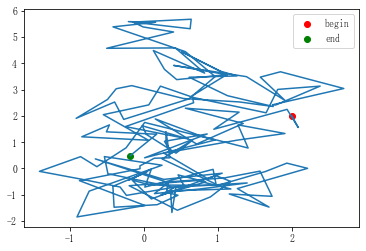

In [9]:
from maysics.algorithm import SA
from matplotlib import pyplot as plt


# 定义被优化函数
def select(x):
    return (x[0]-1)**2 + (x[1]-1)**2


sa = SA(random_state=100)
# 设定初始点为(2, 2)
# 设定初始温度为100，退火温度为20
sa.fit(select, 100, 20, [2, 2])

plt.plot(sa.trace[:, 0], sa.trace[:, 1])
plt.scatter(sa.trace[0,0], sa.trace[0,1], color='red', label='begin')
plt.scatter(sa.trace[-1,0], sa.trace[-1,1], color='green', label='end')
plt.legend()

<br></br>
## GD：梯度下降算法
用法类似SA
<br>注意：默认最小值点为最优点
### DEMO 4-1：求函数$f(x, y) = (x - 1)^{2} + (y - 1)^{2}$的最小值

In [10]:
from maysics.algorithm import GD


# 定义被优化函数
def select(x):
    return (x[0]-1)**2 + (x[1]-1)**2


gd = GD()
# 设定初始点为(10, 10)
# 设定初始温度为100，退火温度为20
gd.fit(select, [10, 10])

print('最小值点：', gd.solution)
print('最小值：', gd.value)

最小值点： [1.08301035 1.08301035]
最小值： 0.01378143586029789


### DEMO 4-2：求函数$f(x, y) = (x - 1)^{2} + (y - 1)^{2}$的最小值求解轨迹

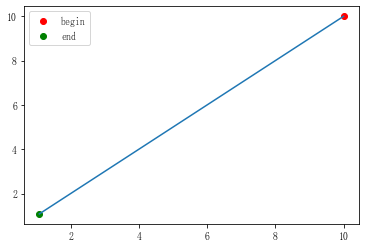

In [11]:
from maysics.algorithm import GD
from matplotlib import pyplot as plt


# 定义被优化函数
def select(x):
    return (x[0]-1)**2 + (x[1]-1)**2


gd = GD()
# 设定初始点为(10, 10)
# 设定初始温度为100，退火温度为20
gd.fit(select, [10, 10])

plt.plot(gd.trace[:, 0], gd.trace[:, 1])
plt.scatter(gd.trace[0,0], gd.trace[0,1], color='red', label='begin')
plt.scatter(gd.trace[-1,0], gd.trace[-1,1], color='green', label='end')
plt.legend()

<br></br>
## GM：灰色系统模型GM(1, 1)
### 调整级比时的精度
<br>在实例化类时可以设置参数acc，默认gm = GM(acc=1)
<br>在调整级比时，模型会将数列循环平移acc个单位，直到$\lambda(k)$∈$(e^{-2/(n+1)}, e^{2/(n+2)})$
<br>其中，$\lambda(k)=\frac{x(0)(k-1)}{x(0)(k)}$，$k = 2, 3, ..., n$
<br>最后平移的长度可以通过调用C属性获取
### DEMO 5-1：acc参数调用和C属性获取

In [12]:
from maysics.algorithm import GM

year = [-3, 2, 4, 8, 11]

gm = GM(acc=1)
gm.fit(year)
print('acc=1：', gm.C)

gm = GM(acc=0.1)
gm.fit(year)
print('acc=0.1：', gm.C)

acc=1： 16
acc=0.1： 15.69999999999996


### DEMO 5-2：灾变预测：已知出现灾害的年份为(3, 8, 10, 14, 17)，求多少年后出现下一次灾害

In [13]:
from maysics.algorithm import GM


year = [3, 8, 10, 14, 17]

gm = GM()
gm.fit(year)

year_6 = gm.predict(6)
delta_year = year_6 - 17

print('第六次灾害年份：', year_6)
print('间隔时间：', delta_year)

第六次灾害年份： 21.122255207674726
间隔时间： 4.122255207674726


因此第六次灾害年份约为21，约4年后出现下一次灾害